In [182]:
# MySQL
import psycopg2
import mysql.connector
# Numpy and Dataframe
import numpy as np
import pandas as pd
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [183]:
# Connect database
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="password"
)
mycursor = mydb.cursor()

In [184]:
# Extract dataset
mycursor.execute(
    "SELECT date, brand, price\
    FROM base.WA_fuel\
    WHERE (fuel = 'ULP') AND (postcode = 6000)"
)

result = mycursor.fetchall()

In [185]:
for x in result:
    print(x)

('01/01/2019', 'Caltex', 139.7)
('01/01/2019', 'Caltex', 139.7)
('01/01/2019', 'Caltex', 139.7)
('01/01/2019', 'Coles Express', 142.9)
('01/01/2019', 'Liberty', 132.4)
('02/01/2019', 'Caltex', 136.7)
('02/01/2019', 'Caltex', 136.7)
('02/01/2019', 'Caltex', 136.7)
('02/01/2019', 'Coles Express', 140.9)
('02/01/2019', 'Liberty', 132.4)
('03/01/2019', 'Caltex', 133.9)
('03/01/2019', 'Caltex', 133.9)
('03/01/2019', 'Caltex', 134.3)
('03/01/2019', 'Coles Express', 138.9)
('03/01/2019', 'Liberty', 132.4)
('04/01/2019', 'Caltex', 131.9)
('04/01/2019', 'Caltex', 131.9)
('04/01/2019', 'Caltex', 131.9)
('04/01/2019', 'Coles Express', 136.9)
('04/01/2019', 'Liberty', 132.4)
('05/01/2019', 'Caltex', 125.5)
('05/01/2019', 'Caltex', 125.5)
('05/01/2019', 'Caltex', 125.5)
('05/01/2019', 'Coles Express', 132.9)
('05/01/2019', 'Liberty', 132.4)
('06/01/2019', 'Caltex', 123.5)
('06/01/2019', 'Caltex', 123.5)
('06/01/2019', 'Caltex', 119.5)
('06/01/2019', 'Coles Express', 129.9)
('06/01/2019', 'Liberty',

In [186]:
# Turn SQL result into dataframe
df = pd.DataFrame(result, columns=['date','brand','price'])
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
df.head(10)

Number of rows: 8055
Number of columns: 3


,date,brand,price
0,01/01/2019,Caltex,139.7
1,01/01/2019,Caltex,139.7
2,01/01/2019,Caltex,139.7
3,01/01/2019,Coles Express,142.9
4,01/01/2019,Liberty,132.4
5,02/01/2019,Caltex,136.7
6,02/01/2019,Caltex,136.7
7,02/01/2019,Caltex,136.7
8,02/01/2019,Coles Express,140.9
9,02/01/2019,Liberty,132.4


In [187]:
df.drop_duplicates(inplace=True)
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
df.reset_index(drop=True, inplace=True)
df.head(10)

Number of rows: 7028
Number of columns: 3


,date,brand,price
0,01/01/2019,Caltex,139.7
1,01/01/2019,Coles Express,142.9
2,01/01/2019,Liberty,132.4
3,02/01/2019,Caltex,136.7
4,02/01/2019,Coles Express,140.9
5,02/01/2019,Liberty,132.4
6,03/01/2019,Caltex,133.9
7,03/01/2019,Caltex,134.3
8,03/01/2019,Coles Express,138.9
9,03/01/2019,Liberty,132.4


In [188]:
# Convert date column into datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [189]:
df.head()

,date,brand,price
0,2019-01-01,Caltex,139.7
1,2019-01-01,Coles Express,142.9
2,2019-01-01,Liberty,132.4
3,2019-01-02,Caltex,136.7
4,2019-01-02,Coles Express,140.9


In [190]:
# Congregate data using months
df['month_year'] = df['date'].dt.to_period('M')
df['date'] = df['month_year']

In [191]:
# Group dataset by date and aggregate by price's mean
df_uni = df.groupby(['date'])['price'].agg('mean')
df_uni

date
2019-01    132.023148
2019-02    134.280198
2019-03    139.475701
2019-04    147.840206
2019-05    152.541489
              ...    
2024-08    184.012903
2024-09    174.675000
2024-10    175.674194
2024-11    172.775000
2024-12    174.941667
Freq: M, Name: price, Length: 72, dtype: float64

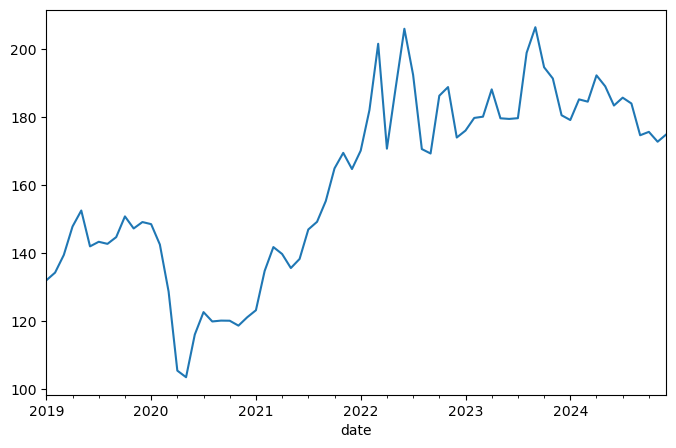

(-1.192307768997332,
 0.6768959312095227,
 2,
 69,
 {'1%': -3.528889992207215,
  '5%': -2.9044395987933362,
  '10%': -2.589655654274312},
 437.1916843762741)

In [192]:
# Testing trend stationarity
from statsmodels.tsa.stattools import adfuller

fig, ax = plt.subplots(figsize=(8,5))
df_uni.plot(ax=ax)
plt.show()

adfuller(df_uni)

$p$ value is .677. Thus, cannot reject null hypothesis that the time series is non-stationary.

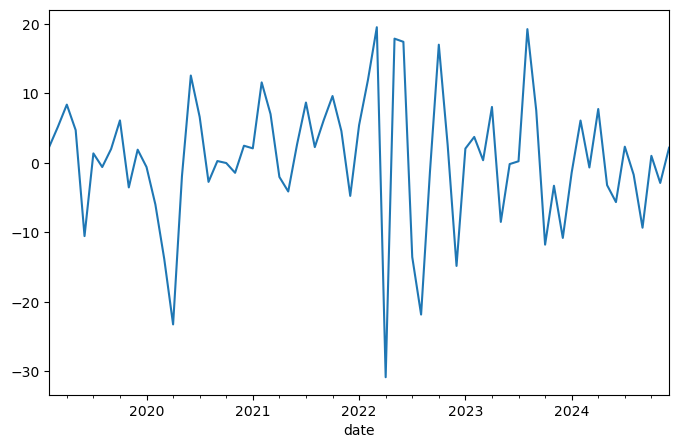

(-8.13817804927637,
 1.0454108109952387e-12,
 1,
 69,
 {'1%': -3.528889992207215,
  '5%': -2.9044395987933362,
  '10%': -2.589655654274312},
 429.60848066331334)

In [193]:
# Take first difference and test again
df_uni_1diff = df_uni.diff(1).dropna()

fig, ax = plt.subplots(figsize=(8,5))
df_uni_1diff.plot(ax=ax)
plt.show()

adfuller(df_uni_1diff)

$p$ value less than .05. Null hypothesis rejected. The transformed time series is stationary.

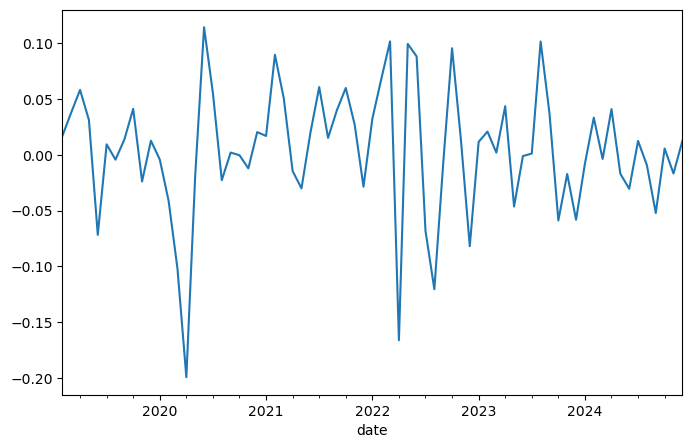

(-7.645857467271788,
 1.8435323311266343e-11,
 1,
 69,
 {'1%': -3.528889992207215,
  '5%': -2.9044395987933362,
  '10%': -2.589655654274312},
 -161.87835491871454)

In [194]:
# Try log-return and test again
df_uni_logreturn = np.log(df_uni/df_uni.shift(1)).dropna()

fig, ax = plt.subplots(figsize=(8,5))
df_uni_logreturn.plot(ax=ax)
plt.show()

adfuller(df_uni_logreturn)

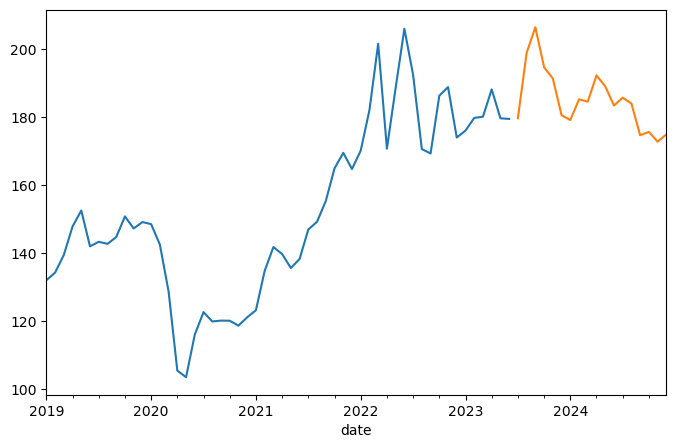

In [195]:
# Training and testing datasets
train = df_uni.iloc[:round(.75*len(df_uni))]
test = df_uni.iloc[round(.75*len(df_uni)):]
fig, ax = plt.subplots(figsize=(8,5))
train.plot(ax=ax)
test.plot(ax=ax)
plt.show()

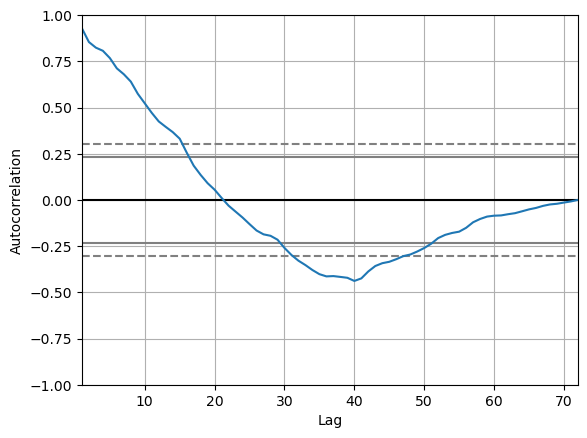

In [196]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_uni)
plt.show()

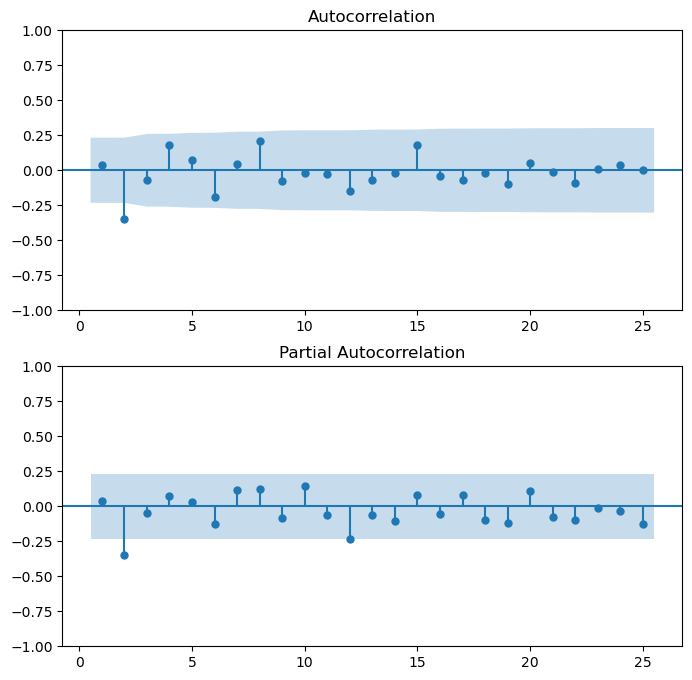

In [197]:
# plot ACF and PACF graphs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

plot_acf(df_uni_1diff, lags=25, zero=False, ax=ax1)
plot_pacf(df_uni_1diff, lags=25, zero=False, ax=ax2)
plt.show()

In [198]:
# Search for the best order by AIC and BIC
order_aic_bic = []

for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(df_uni, order=(p,1,q))
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            order_aic_bic.append((p, q, None, None))

order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic', 'bic'])

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/

In [199]:
order_df.sort_values(['aic', 'bic'])

,p,q,aic,bic
10,2,0,515.400422,522.188461
2,0,2,516.960839,523.748879
15,3,0,517.266239,526.316958
11,2,1,517.308740,526.359459
13,2,3,518.084605,531.660684
22,4,2,518.139702,533.978461
12,2,2,518.321434,529.634833
14,2,4,518.815523,534.654282
20,4,0,518.861549,530.174948
3,0,3,518.883601,527.934321


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   72
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -254.700
Date:                Wed, 25 Dec 2024   AIC                            515.400
Time:                        21:51:25   BIC                            522.188
Sample:                    01-31-2019   HQIC                           518.100
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0545      0.073      0.743      0.458      -0.089       0.198
ar.L2         -0.3370      0.093     -3.632      0.000      -0.519      -0.155
sigma2        76.1990     10.032      7.595      0.0

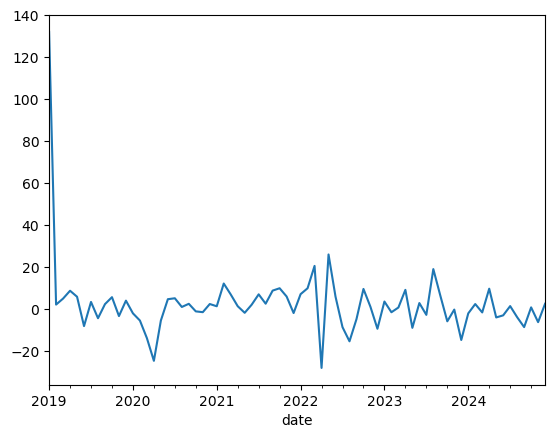

MAE:8.138634096900375


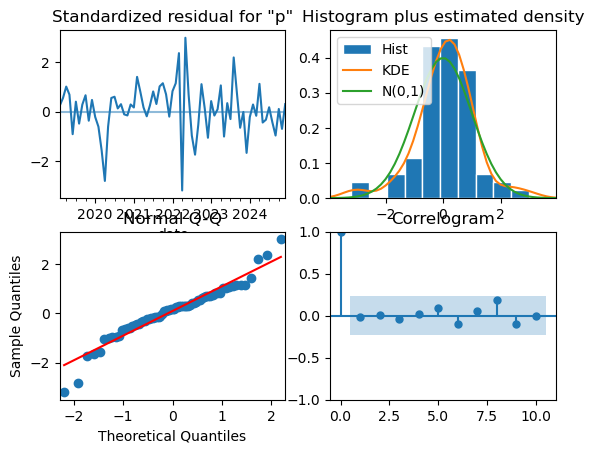

count     72.000000
mean       2.603686
std       17.744562
min      -27.889964
25%       -3.345231
50%        1.508551
75%        6.004867
max      132.023148
dtype: float64


In [200]:
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(df_uni, order=(2,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = model_fit.resid
residuals.plot()
plt.show()
# Mean absolute error (MAE)
mae = np.mean(np.abs(residuals))
print(f'MAE:{mae}')
# density plot of residuals - white Gaussian noise should be centred around 0
model_fit.plot_diagnostics()
plt.show()
# residuals.plot(kind='kde')
# plt.show()
# summary stats of residuals
print(residuals.describe())

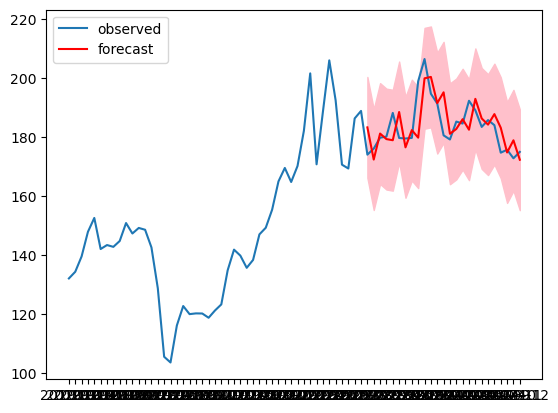

In [201]:
# Forecast (one-step ahead in-sample prediction)
forecast = model_fit.get_prediction(start=-25)
# Mean forecast
mean_forecast = forecast.predicted_mean
# Confident intervals
conf_int = forecast.conf_int()

# Plot
plt.figure()
plt.plot(df_uni.index.to_series().astype('str'), df_uni, label='observed')
# Prediction
plt.plot(mean_forecast.index.to_series().astype('str'), mean_forecast.values, color='red', label='forecast')
# Uncertainty area
plt.fill_between(mean_forecast.index.to_series().astype('str'), conf_int['lower price'], conf_int['upper price'], color='pink')
plt.legend()
plt.show()

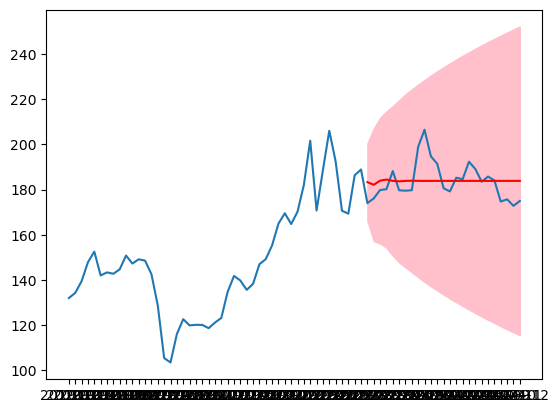

In [202]:
# Forecast (Dynamic in-sample prediction)
forecast = model_fit.get_prediction(start=-25, dynamic=True)
# Mean forecast
mean_forecast = forecast.predicted_mean
# Confident intervals
conf_int = forecast.conf_int()

# Plot
plt.figure()
plt.plot(df_uni.index.to_series().astype('str'), df_uni)
# Prediction
plt.plot(mean_forecast.index.to_series().astype('str'), mean_forecast.values, color='red', label='forecast')
# Uncertainty area
plt.fill_between(mean_forecast.index.to_series().astype('str'), conf_int['lower price'], conf_int['upper price'], color='pink')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


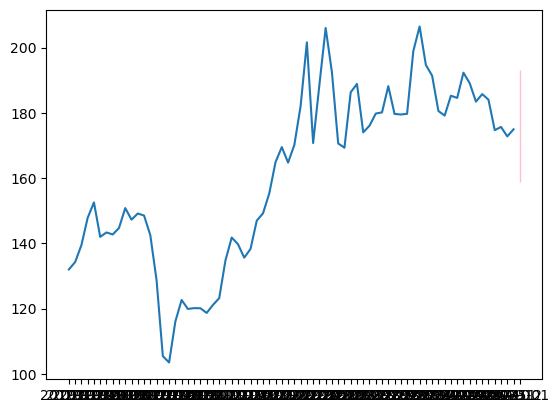

In [203]:
# Forecast (Out-sample prediction)
forecast = model_fit.get_forecast(step=10)
# Mean forecast
mean_forecast = forecast.predicted_mean
# Confident intervals
conf_int = forecast.conf_int()

# Plot
plt.figure()
plt.plot(df_uni.index.to_series().astype('str'), df_uni)
# Prediction
plt.plot(mean_forecast.index.to_series().astype('str'), mean_forecast.values, color='red', label='forecast')
# Uncertainty area
plt.fill_between(mean_forecast.index.to_series().astype('str'), conf_int['lower price'], conf_int['upper price'], color='pink')
plt.show()

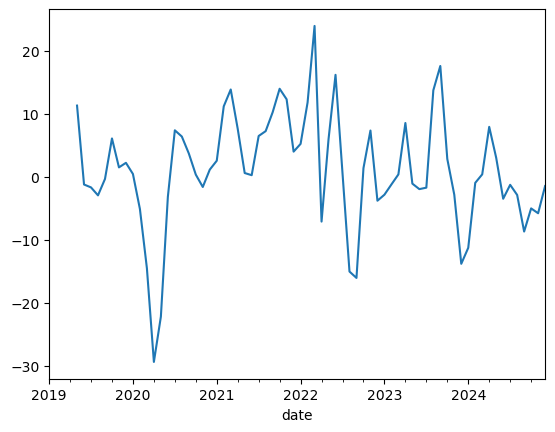

In [204]:
# De-trend the time-series to determine the cycle period
df_detrend = df_uni - df_uni.rolling(5).mean()
df_detrend.dropna()
df_detrend.plot()
plt.show()

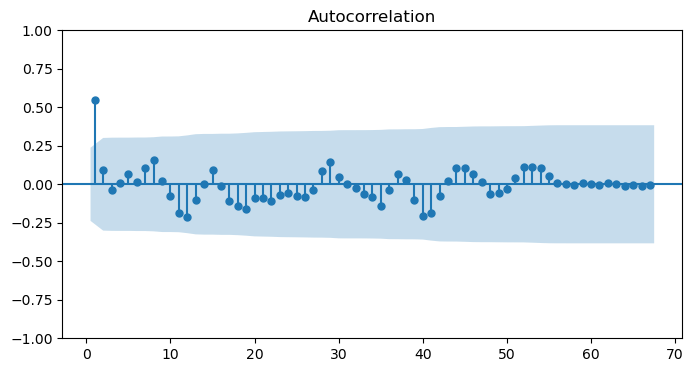

In [205]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,1, figsize=(8,4))

plot_acf(df_detrend.dropna(), lags=67, zero=False, ax=ax)
plt.show()

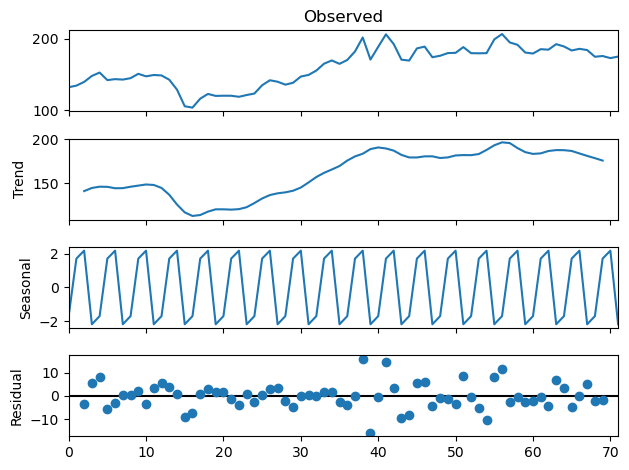

In [206]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_results = seasonal_decompose(df_uni.values, period=4)
decomp_results.plot()
plt.show()

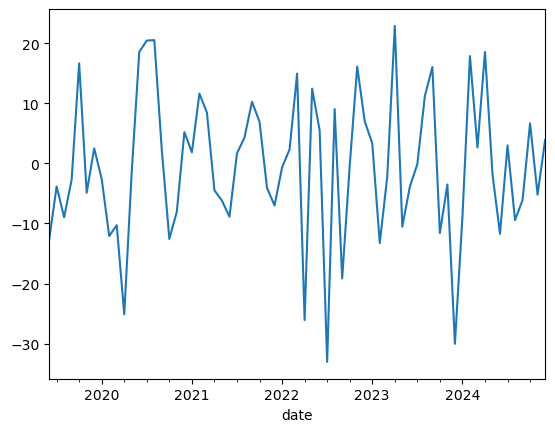

In [226]:
# Seasonal differencing 
df_uni_season_diff = df_uni.diff(4).diff().dropna()
df_uni_season_diff.plot()
plt.show()

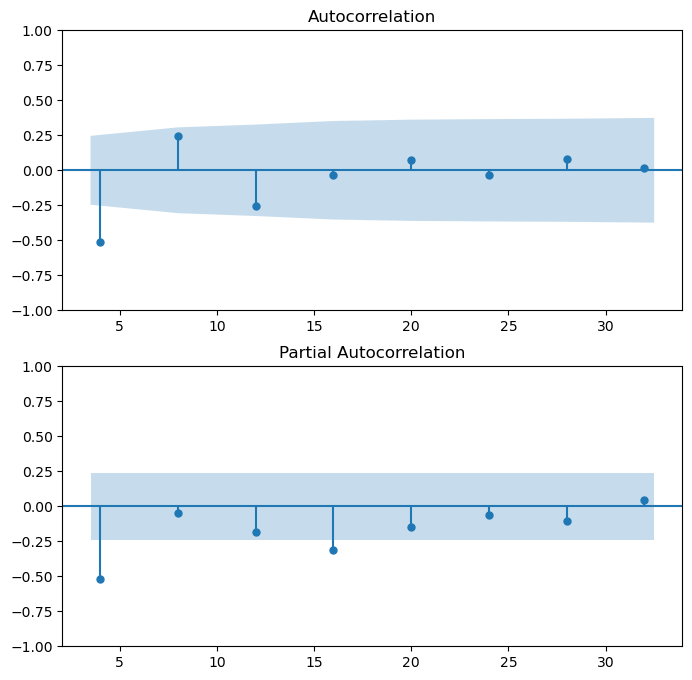

In [208]:
# plot seasonal ACF and PACF graphs
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
lags = [i for i in range(4,36,4)]
plot_acf(df_uni_season_diff, lags=lags, ax=ax1)
plot_pacf(df_uni_season_diff, lags=lags, ax=ax2)
plt.show()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47071D+00    |proj g|=  6.54499D-02

At iterate    5    f=  3.43312D+00    |proj g|=  5.59124D-02

At iterate   10    f=  3.39691D+00    |proj g|=  6.61022D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14     17      1     0     0   2.047D-05   3.397D+00
  F =   3.3968802698792100     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                  

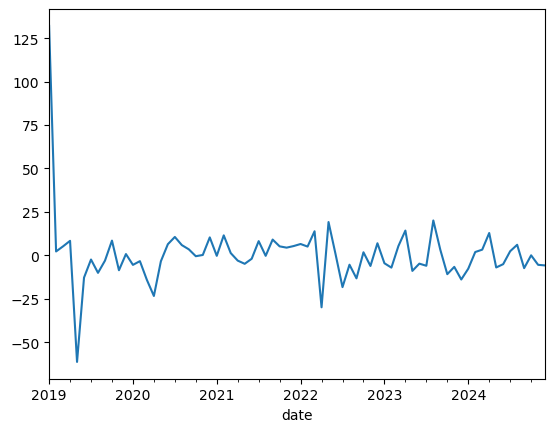

MAE:9.655658337565924


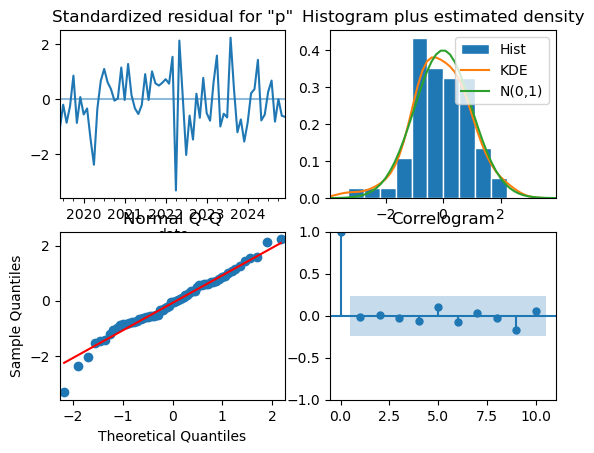

count     72.000000
mean       0.423499
std       19.513585
min      -61.310051
25%       -6.009020
50%       -0.116890
75%        5.492165
max      132.023148
dtype: float64


In [228]:
# Apply SARIMA to capture seasonal patterns
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df_uni, order=(2,1,0), seasonal_order=(4,1,0,4))
results = model.fit()

# summary of fit model
print(results.summary())
# line plot of residuals
residuals = results.resid
residuals.plot()
plt.show()
# Mean absolute error (MAE)
mae = np.mean(np.abs(residuals))
print(f'MAE:{mae}')
# density plot of residuals - white Gaussian noise should be centred around 0
results.plot_diagnostics()
plt.show()
# residuals.plot(kind='kde')
# plt.show()
# summary stats of residuals
print(residuals.describe())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[4]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=526.274, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=510.198, Time=0.01 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=528.171, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=512.184, Time=0.03 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=514.155, Time=0.12 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=508.422, Time=0.02 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=510.411, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=inf, Time=0.03 sec
 ARIMA(0,1,0)(2,1,1)[4]             : AIC=512.358, Time=0.05 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=510.019, Time=0.02 sec
 ARIMA

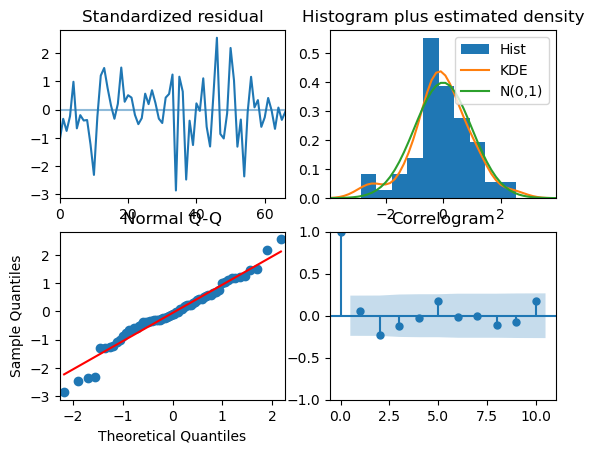

['model.pkl']

In [229]:
# Searching over model orders
import pmdarima as pm
import joblib
results = pm.auto_arima(df_uni.values, seasonal=True, d=1, m=4, D=1, information_criterion='aic', trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
# Update parameters with new observations
# results.update(df_new)
print(results.summary())
results.plot_diagnostics()
plt.show()

joblib.dump(results, "model.pkl")

# Load model
# model_results_object = joblib.load("model.pkl")

In [97]:
# Connect database for weather data
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="password"
)
mycursor = mydb.cursor()

# Extract dataset
mycursor.execute(
    "SELECT CONCAT(year, '-', month) AS month, ROUND(AVG(temp_max), 1) AS temp_max\
    FROM base.weather\
    WHERE year >= 2019\
    GROUP BY year, month\
    LIMIT 5"
)

result = mycursor.fetchall()

for x in result:
    print(x)

('2019-01', 30.5)
('2019-02', 31.3)
('2019-03', 30.1)
('2019-04', 25.6)
('2019-05', 22.2)
